<a href="https://colab.research.google.com/github/jakubmis1998/NeuralNetworks/blob/main/robotHand.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [324]:
import numpy as np
import matplotlib.pyplot as plt

In [331]:
class NeuralNetwork:

  def __init__(self, layers, learning_rate):
    """
      Args:
        layers (NumPy 1D array): array with the number of layers ex. [2, 4, 4, 2].
    """
    self.learning_rate = learning_rate
    self.hand_range = 50
    self.layers_number = len(layers)
    self.weights = [0] * self.layers_number
    self.bias = [0] * self.layers_number
    self.current_values_after_activate_function = [0] * self.layers_number
    self.current_values_before_activate_function = [0] * self.layers_number
    self.deltas = [0] * self.layers_number
    self.small_deltas = [0] * self.layers_number
    for i in range(self.layers_number - 1):
      self.weights[i + 1] = np.random.uniform(-0.5, 0.5, (layers[i], layers[i + 1]))
      self.bias[i + 1] = np.random.uniform(-0.5, 0.5, layers[i + 1])

  def back_propagation(self, sample):
    """
      Fixes deltas and updates weights.

      Args:
        sample ([float, float]) - Random normalized degrees. (0.1 - 0.9)
    """
    self.deltas[-1] = (self.current_values_after_activate_function[-1] - sample) * self.derivativeSigmoid(self.current_values_after_activate_function[-1])

    for i in reversed(range(1, self.layers_number - 1)):
      self.small_deltas[i] = self.deltas[i + 1].dot(self.weights[i + 1].T)
      self.deltas[i] = self.small_deltas[i] * self.derivativeSigmoid(self.current_values_after_activate_function[i])

    for i in range(1, self.layers_number):
      y = np.copy(self.current_values_after_activate_function[i - 1])
      deltas = np.copy(self.deltas[i])
      self.weights[i] -= self.learning_rate * np.dot(y.reshape(len(y), 1), deltas.reshape(1, len(deltas)))
      self.bias[i] -= self.learning_rate * deltas

  def train(self, epochs):
    """
      Trains neural networks.

      Args:
        epochs (integer): Number of iterations.
    """
    for i in range(epochs):
      # Random sample
      sample = self.rand_radians()
      # Calculate truthy coordinates
      self.current_values_after_activate_function[0] = self.calculate_coordinates(sample)
      # Normalization coordinates (-100 - 100  =>  -1 - 1)
      self.current_values_after_activate_function[0] /= (self.hand_range * 2)
      # Normalization degrees (0 - 180  =>  0.1 - 0.9)
      sample = self.normalize_degrees(sample)

      # Step forward
      self.step_forward()

      # Fix deltas
      self.back_propagation(sample)

      if i % 10000 == 0:
        print("Progress: {}%".format(np.around(i / epochs * 100, decimals=1)))

  def step_forward(self):
    """
      Updates weights and remembers previous values for back propagation.
    """
    # Go over layers and predict angles
    for i in range(1, self.layers_number):
      self.current_values_before_activate_function[i] = np.dot(self.current_values_after_activate_function[i - 1], self.weights[i]) + self.bias[i]
      self.current_values_after_activate_function[i] = self.sigmoid(self.current_values_before_activate_function[i])
  
  def predict(self, coordinates):
    """
      Returns predicted angles of robot arm using neural network and given coordinates.

      Args:
        coordinates ([float, float]): Coordinates for which will be predicted angles.
    """
    # Put coordinates in input layer
    self.current_values_after_activate_function[0] = coordinates

    # Go over layers and predict angles
    for i in range(1, self.layers_number):
      self.current_values_before_activate_function[i] = np.dot(self.current_values_after_activate_function[i - 1], self.weights[i]) + self.bias[i]
      self.current_values_after_activate_function[i] = self.sigmoid(self.current_values_before_activate_function[i])

    # Unnormalization angles from last layer
    radians_input_degree = self.unnormalize_degrees(self.current_values_after_activate_function[-1])
    return radians_input_degree
  
  def sigmoid(self, x):
    """
      Activation function.
      Returns function value for given argument.

      Args: x (number): Argument for which the function value will be returned.
    """
    return 1 / (1 + np.exp(-x))
  
  def derivativeSigmoid(self, x):
    """
      Derivative of activation function.
      Returns function value for given argument.

      Args: x (number): Argument for which the function value will be returned.
    """
    return x * (1 - x)

  def rand_degrees(self):
    """Returns two angles in degrees (0 - 180)."""
    return np.random.rand(2) * 180
  
  def rand_radians(self):
    """Returns two angles in radians (0 - 3.14159)."""
    degrees = self.rand_degrees()
    return np.array([ np.radians(degrees[0]), np.radians(degrees[1]) ])

  def normalize_degrees(self, degrees):
    """
      Returns two normalized degrees (0.1 - 0.9).

      Args:
        degrees ([float, float]): Unnormalized angles in degrees (0 - 180).
    """
    normalized_degrees = []
    for degree in degrees:
      normalized_degrees.append(0.8 * degree / np.radians(180) + 0.1)
    return normalized_degrees
  
  def unnormalize_degrees(self, degrees):
    """
      Returns two unnormalized degrees (0 - 180).

      Args:
        degrees ([float, float]): Normalized angles in degrees (0.1 - 0.9).
    """
    unnormalized_degrees = []
    for degree in degrees:
      unnormalized_degrees.append((degree - 0.1) * np.radians(180) / 0.8)
    return unnormalized_degrees
  
  def calculate_coordinates(self, angles):
    """
      Formula for the rotation of a line relative to a point by the angle alpha.
      Returns coordinates the end point of the second robot arm.

      Args:
        angles ([float, float]): Angle between the OY axis and the first robot arm, Angle between the first and the second robot arm in radians.
    """
    # Wspolrzedna x końca pierwszego ramienia - kąt miedzy osia OY a pierwszym ramieniem
    xa = self.hand_range * np.sin(angles[0])
    # Wspolrzedna y końca pierwszego ramienia - kąt miedzy osia OY a pierwszym ramieniem
    ya = -self.hand_range * np.cos(angles[0])

    # Wspolrzedna x końca drugiego ramienia - kąt pomiędzy pierwszym a drugim ramieniem
    xb = xa + (0 - xa) * np.cos(angles[1]) + (0 - ya) * np.sin(angles[1])
    # Wspolrzedna y końca drugiego ramienia - kąt pomiędzy pierwszym a drugim ramieniem
    yb = ya + (0 + xa) * np.sin(angles[1]) + (0 - ya) * np.cos(angles[1])
  
    return np.array([xb, yb])

In [334]:
# 2 - Input layer - (x, y)
# 8 - Hidden layer - 8 neurons
# 8 - Hidden layer - 8 neurons
# 2 - Output layer - (alpha, beta)
nw = NeuralNetwork([2, 8, 8, 2], 0.1)
nw.train(2000000)

Progress: 0.0%
Progress: 0.5%
Progress: 1.0%
Progress: 1.5%
Progress: 2.0%
Progress: 2.5%
Progress: 3.0%
Progress: 3.5%
Progress: 4.0%
Progress: 4.5%
Progress: 5.0%
Progress: 5.5%
Progress: 6.0%
Progress: 6.5%
Progress: 7.0%
Progress: 7.5%
Progress: 8.0%
Progress: 8.5%
Progress: 9.0%
Progress: 9.5%
Progress: 10.0%
Progress: 10.5%
Progress: 11.0%
Progress: 11.5%
Progress: 12.0%
Progress: 12.5%
Progress: 13.0%
Progress: 13.5%
Progress: 14.0%
Progress: 14.5%
Progress: 15.0%
Progress: 15.5%
Progress: 16.0%
Progress: 16.5%
Progress: 17.0%
Progress: 17.5%
Progress: 18.0%
Progress: 18.5%
Progress: 19.0%
Progress: 19.5%
Progress: 20.0%
Progress: 20.5%
Progress: 21.0%
Progress: 21.5%
Progress: 22.0%
Progress: 22.5%
Progress: 23.0%
Progress: 23.5%
Progress: 24.0%
Progress: 24.5%
Progress: 25.0%
Progress: 25.5%
Progress: 26.0%
Progress: 26.5%
Progress: 27.0%
Progress: 27.5%
Progress: 28.0%
Progress: 28.5%
Progress: 29.0%
Progress: 29.5%
Progress: 30.0%
Progress: 30.5%
Progress: 31.0%
Progress: 31

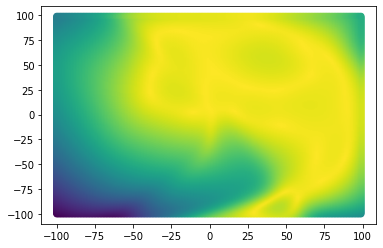

In [337]:
# Plot

x = y = [i for i in range(-100, 100)]
# Cartesian product 200 x 200
A = np.transpose([np.tile(x, len(y)), np.repeat(y, len(x))])

distance_differences = []

for i in range(len(A)):
  predicted_radians = nw.predict([A[i][0] / 100, A[i][1] / 100])
  truthy_values = nw.calculate_coordinates(predicted_radians)
  # Distance between predicted and truthy point
  distance_differences.append(-np.sqrt(np.power(truthy_values[0] - A[i][0], 2) + np.power(truthy_values[1] - A[i][1], 2)))

plt.scatter(A[:, 0], A[:, 1], c = distance_differences)

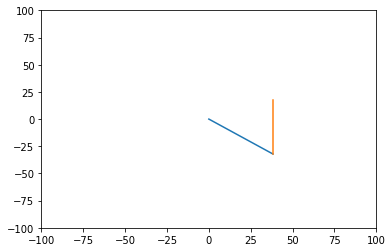

In [293]:
# Test drawing robot arms

alpha = np.radians(50)
beta = np.radians(50)

coordinates = nw.calculate_coordinates([alpha, beta])
plt.xlim(-100, 100)
plt.ylim(-100, 100)
plt.plot([ 0, 50 * np.sin(alpha) ], [ 0, -50 * np.cos(alpha) ])
plt.plot([ 50 * np.sin(alpha), coordinates[0] ], [ -50 * np.cos(alpha), coordinates[1] ])